In [1]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Extra data

In [2]:
chrom_sizes = {'chr1' : 248956422,
               'chr2' : 242193529,
               'chr3' : 198295559,
               'chr4' : 190214555,
               'chr5' : 181538259,
               'chr6' : 170805979,
               'chr7' : 159345973,
               'chr8' : 145138636,
               'chr9' : 138394717,
               'chr10' : 133797422,
               'chr11' : 135086622,
               'chr12' : 133275309,
               'chr13' : 114364328,
               'chr14' : 107043718,
               'chr15' : 101991189,
               'chr16' : 90338345,
               'chr17' : 83257441,
               'chr18' : 80373285,
               'chr19' : 58617616,
               'chr20' : 64444167,
               'chr21' : 46709983,
               'chr22' : 50818468,
               'chrX' : 156040895,
               'chrY' : 57227415,
              }

# Functions

In [3]:
def read_pairs_file(filename, file_format='gzip'):
    '''
    This function reads a .pairs or .pairs.gz generated from iMARGI.
    
    Parameters
    __________
    
    filename : str
        It is the path to the iMARGI file.
    file_format : str
        It could be gzip or uncompress. Here, we use gzip by default.
        
    Returns
    _______
    
    df : DataFrame
        Pandas dataframe containing all interactions. Columns are 'chrA', 'posA', 'chrB' and 'posB'.
    '''
    entries = []
    if file_format == 'gzip':
        with gzip.open(filename, 'rb') as f:
            for i, line in enumerate(f):
                if i % 1000000 == 0:
                    print("Reading line {}".format(i))
                    
                line = line.decode()
                if line.startswith('#'):
                    continue 

                line = line.strip()
                vals = line.split()
                chromA_, posA, chromB_, posB = vals[1:5]
                posA, posB = int(posA), int(posB)
                
                entries.append((chromA_, posA, chromB_, posB))
    else:
        with open(filename, 'rb') as f:
            for i, line in enumerate(f):
                if i % 1000000 == 0:
                    print("Reading line {}".format(i))
                    
                line = line.decode()    
                if line.startswith('#'):
                    continue 

                line = line.strip()
                vals = line.split()
                chromA_, posA, chromB_, posB = vals[1:5]
                posA, posB = int(posA), int(posB)
                
                entries.append((chromA_, posA, chromB_, posB))
    df = pd.DataFrame.from_records(entries, columns=['chrA', 'posA', 'chrB', 'posB'])
    del entries
    return df

In [4]:
def filter_interaction_df(df, chrA=None, chrA_positions=None, chrB=None, chrB_positions=None):
    '''
    This function filters interactions according to chrA and chrB specified.Also, a window of positions
    can be provided for those chromosomes.
    
    Parameters
    __________
    
    df : DataFrame
        Pandas DataFrame containing interactions.
    
    chrA : str
        Chromosome to keep in column chrA of df. None by default.
        
    chrA_positions : tuple
        Tuple containing the start and the end of the windows of interactions. They corresponds to positions in
        chrA (posA in df). None by default.
        
    chrB : str
        Chromosome to keep in column chrB of df. None by default.
        
    chrB_positions : tuple
        Tuple containing the start and the end of the windows of interactions. They corresponds to positions in
        chrB (posB in df). None by default.
        
    Returns
    _______
    
    df_ : DataFrame
        Pandas dataframe containing all interactions after filtering df.
    '''
    df_ = df.copy()

    if chrA is not None:
        if chrA_positions is not None:
            df_ = df_.loc[(df_['chrA'] == chrA) & \
                          (df_['posA'].between(chrA_positions[0], chrA_positions[1], inclusive=True))]
        else:
            raise ValueError("Specify positions for ChrA")
            
    if chrB is not None:
        if chrB_positions is not None:
            df_ = df_.loc[(df_['chrB'] == chrB) & \
                          (df_['posB'].between(chrB_positions[0], chrB_positions[1], inclusive=True))]
        else:
            raise ValueError("Specify positions for ChrB")
    
    return df_

In [5]:
def plot_interactions(df, chrA, chrA_positions, chrB, chrB_positions, line_color='green', linewidth=0.5, alpha=0.15,
                      output=None, name=None, symmetric=False):
    '''
    This function plots the interactions between chrA and chrB given a window of positions for each one.
    '''
    fig = plt.figure(figsize=(16, 9))
    ax = plt.gca()
    
    range_A = chrA_positions[1] - chrA_positions[0]
    range_B = chrB_positions[1] - chrB_positions[0]
    
    max_x = max(range_A, range_B)
    
    ax.set_xlim(-max_x*.05, max_x*1.05)
    ax.set_ylim(-1, 2)
    
    up_pos = .45
    low_pos = -.45
    text_factor = 0.4
    
    # UPPER CHROM (chrA)
    ax.text(max_x/2, 1+up_pos, chrA, horizontalalignment='center', verticalalignment='center', fontsize=30)
    ax.add_line(plt.Line2D([0, max_x], [1.05, 1.05], linewidth=15, color='k', solid_capstyle='round'))
    
    # Coordinates  
    for frac in [0, 0.25, 0.5, 0.75, 1]:
        location = chrA_positions[0] + int(range_A*frac)
        ax.add_line(plt.Line2D([max_x*frac, max_x*frac], [1.05, 1+text_factor*up_pos], linewidth=0.5, color='gray'))
        ax.text(max_x*frac, 1+text_factor*up_pos, "{:,}".format(location),
                horizontalalignment='center', verticalalignment='baseline', fontsize=10)
    
    # LOWER CHROM(chrB)
    ax.add_line(plt.Line2D([0, max_x], [-0.05, -0.05], linewidth=15, color='k', solid_capstyle='round'))
    ax.text(max_x/2, low_pos, chrB, horizontalalignment='center', verticalalignment='center', fontsize=30)
    
    # Coordinates    
    for frac in [0, 0.25, 0.5, 0.75, 1]:
        location = chrB_positions[0] + int(range_B*frac)
        ax.add_line(plt.Line2D([max_x*frac, max_x*frac], [-0.05, text_factor*low_pos], linewidth=0.5, color='gray'))
        ax.text(max_x*frac, text_factor*low_pos, "{:,}".format(location),
                horizontalalignment='center', verticalalignment='top', fontsize=10)
    
    df_ = df.copy()
    df_ = filter_interaction_df(df_, chrA, chrA_positions, chrB, chrB_positions)
    
    # Trace lines for interactions
    for index, row in df_.iterrows():
        posA = (row['posA'] - chrA_positions[0]) * max_x / range_A
        posB = (row['posB'] - chrB_positions[0]) * max_x / range_B
        ax.add_line(plt.Line2D([posA, posB], [1, 0], linewidth=linewidth, alpha=alpha, color=line_color))
        
        if symmetric:
            ax.add_line(plt.Line2D([posB, posA], [1, 0], linewidth=linewidth, alpha=alpha, color=line_color))            
    
    ax.axis('off')
    if output is not None:
        if name is None:
            filename = "/{}.{}.{}.{}.{}.{}.png".format(chrA, chrA_positions[0], chrA_positions[1],
                                                       chrB, chrB_positions[0], chrB_positions[1])
        else:
            filename = "/{}_{}.{}.{}.{}.{}.{}.png".format(name, chrA, chrA_positions[0], chrA_positions[1],
                                                          chrB, chrB_positions[0], chrB_positions[1])
        plt.savefig(output + filename, dpi = 300, bbox_inches='tight')
        
    return fig

# Analyses

## Read Files

In [6]:
HEK_file = './iMARGIProcessing/filter200k_final_HEK_iMARGI.pairs.gz'
HFF_file = './iMARGIProcessing/filter200k_final_HFF_iMARGI.pairs.gz'

In [7]:
HEK = read_pairs_file(HEK_file)

Reading line 0
Reading line 1000000
Reading line 2000000
Reading line 3000000
Reading line 4000000
Reading line 5000000
Reading line 6000000
Reading line 7000000
Reading line 8000000
Reading line 9000000
Reading line 10000000
Reading line 11000000
Reading line 12000000
Reading line 13000000
Reading line 14000000
Reading line 15000000
Reading line 16000000
Reading line 17000000
Reading line 18000000
Reading line 19000000
Reading line 20000000


In [12]:
HFF = read_pairs_file(HFF_file)

Reading line 0
Reading line 1000000
Reading line 2000000
Reading line 3000000
Reading line 4000000
Reading line 5000000
Reading line 6000000
Reading line 7000000
Reading line 8000000
Reading line 9000000
Reading line 10000000
Reading line 11000000


## Interactions

In [14]:
outputs = '/Users/earmingol/Dropbox/Universidad/UCSanDiego/Cursos/BENG203/Project/'

**HEK**

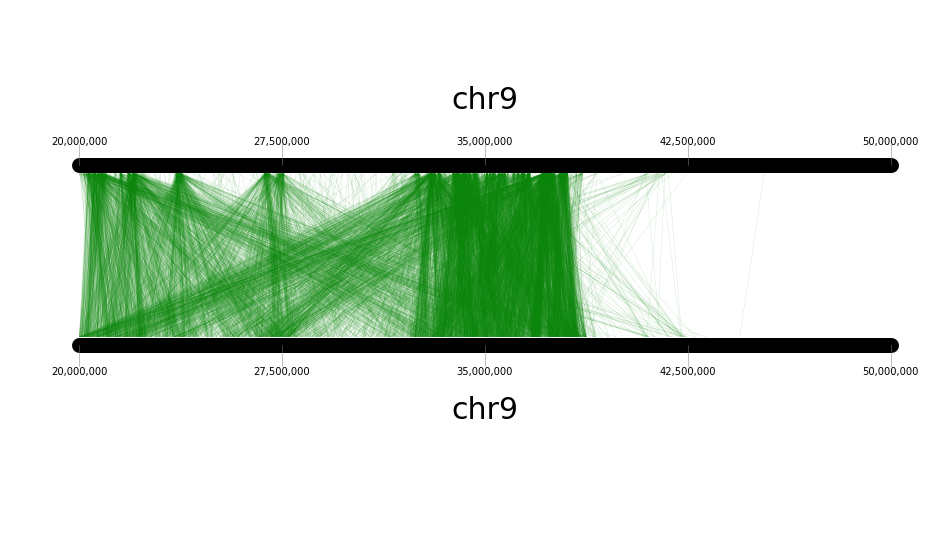

In [141]:
fig_HEK = plot_interactions(HEK, 'chr9', (20000000, 50000000), 'chr9', (20000000, 50000000), output=outputs,
                            )

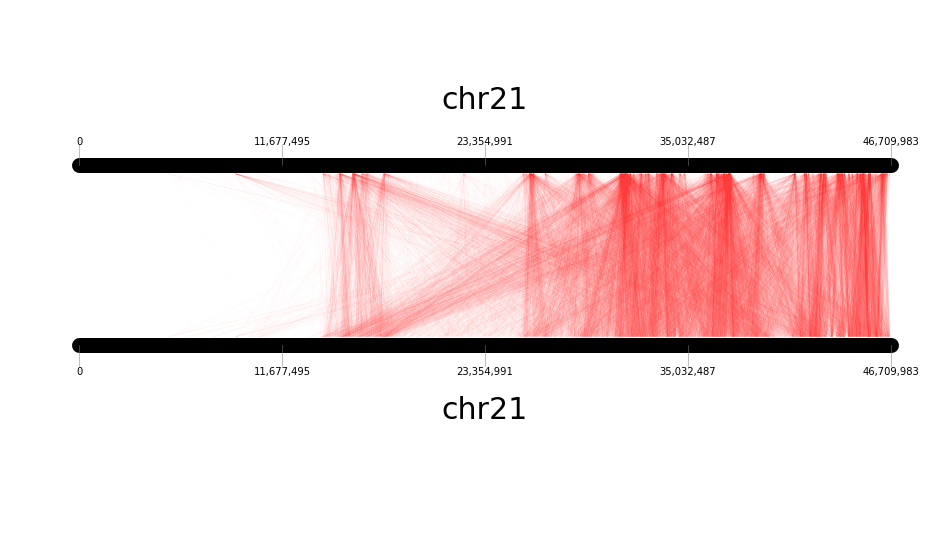

In [11]:
#for chrom, pos in chrom_sizes.items():
chrom = 'chr21'
pos = chrom_sizes[chrom]
chrom_plot = plot_interactions(HEK, chrom, (0, pos), chrom, (0, pos), line_color='red')

**HFF**

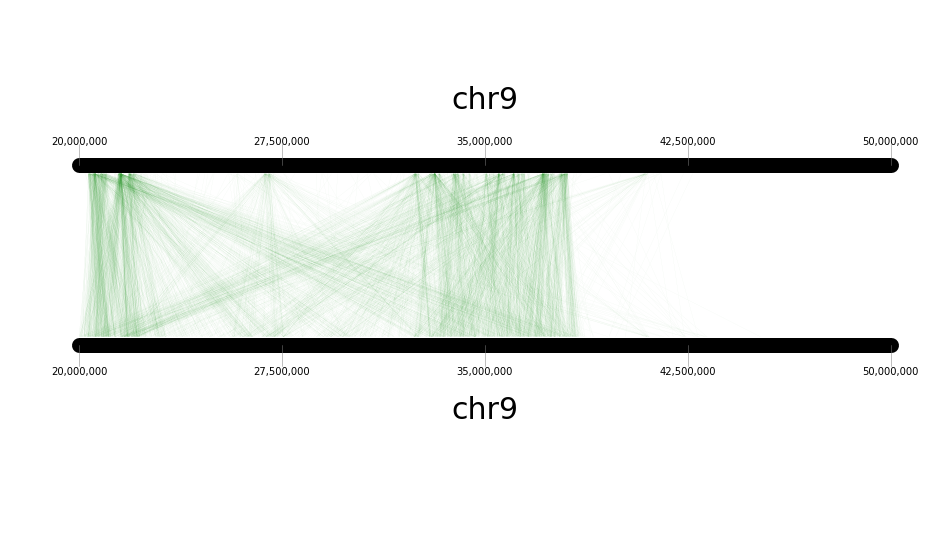

In [12]:
fig_HFF = plot_interactions(HFF, 'chr9', (20000000, 50000000), 'chr9', (20000000, 50000000))

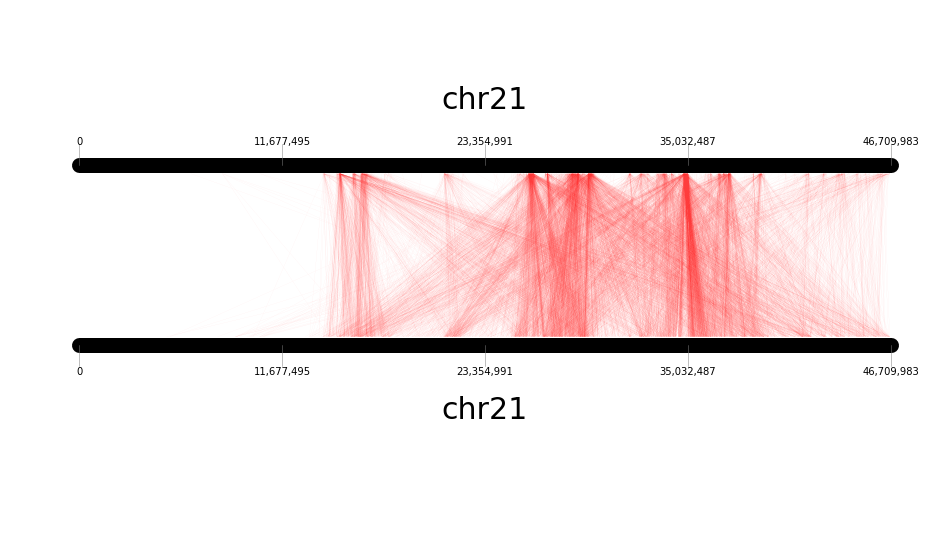

In [13]:
#for chrom, pos in chrom_sizes.items():
chrom = 'chr21'
pos = chrom_sizes[chrom]
chrom_plot = plot_interactions(HFF, chrom, (0, pos), chrom, (0, pos), line_color='red')

# Futra 

In [6]:
def read_futra(filename, file_format='gzip'):
    '''
    This function reads a .gz or .txt file for Fusion Transcripts from https://www.tumorfusions.org/ 
    or https://data.broadinstitute.org/snowman/ofer/SigSV/
    
    Parameters
    __________
    
    filename : str
        It is the path to the Fusion Transcripts file.
    file_format : str
        It could be gzip or uncompress. Here, we use gzip by default.
        
    Returns
    _______
    
    df : DataFrame
        Pandas dataframe containing all futra interactions.
    '''
    if file_format == 'gzip':
        with gzip.open(filename, 'rb') as f:
            for i, line in enumerate(f):
                line = line.decode()
                vals = line.split("\r")  
                values = [tuple(val.split("\t")) for val in vals]
                

    else:
        with open(filename, 'rb') as f:
            for i, line in enumerate(f):
                line = line.decode()
                vals = line.split("\r")  
                values = [tuple(val.split("\t")) for val in vals]
    df = pd.DataFrame.from_records(values[1:], columns=values[0])
    df.rename(columns={'A_chr':'chrA',
                       'B_chr':'chrB',
                       'gene_A_start':'posA',
                       'gene_B_start':'posB'}, inplace=True)
    df['chrA'] = df['chrA'].apply(lambda x: 'chr{}'.format(x))
    df['chrB'] = df['chrB'].apply(lambda x: 'chr{}'.format(x))
    df['posA'] = df['posA'].apply(int)
    df['posB'] = df['posB'].apply(int)
    df['Distance'] = df.apply(lambda row: abs(row['posA'] - row['posB']), axis=1)
    #df = df.loc[((df['chrA'] == df['chrB']) & (df['Distance'] < 200000)) or (df['chrA'] != df['chrB'])]
    df = df.loc[((df['chrA'] == df['chrB']) & (df['Distance'] >= 200000)) | (df['chrA'] != df['chrB'])]
    #df.set_index('Cancer', inplace=True)
    return df

In [7]:
futra = read_futra('./pancanfus.txt.gz')

In [8]:
futra.shape

(15425, 28)

In [9]:
filtered_futra = futra[futra.tier.isin(['tier1', 'tier2'])]

In [10]:
filtered_futra.shape

(12498, 28)

In [11]:
filtered_futra.head()

,Cancer,sampleId,Gene_A,Gene_B,chrA,chrB,A_strand,B_strand,Discordant_n,JSR_n,...,gene_A_end,posB,gene_B_end,phos_A,phos_B,ubiq_A,ubiq_B,WGS,centrality,Distance
0,PRAD,G9.6348.01A,A2LD1,DCLK1,chr13,chr13,-1,-1,2,1,...,101241782,36343122,36705467,0,0,0,0,NA,0.35917,64840679
1,SARC,DX.A48L.01A,A2LD1,INCA1,chr13,chr17,-1,-1,10,2,...,101241782,4988130,4997610,0,0,0,0,NA,0.34827,96195671
5,UCEC,AX.A1C7.01A,AACS,MAL,chr12,chr2,1,1,30,38,...,125143333,95025677,95053996,1,0,0,0,NA,0.34131,30039702
8,OV,24.1423.01A,AAK1,C2orf42,chr2,chr2,-1,-1,50,49,...,69901481,70377012,70475747,1,0,0,0,NA,0,688480
9,PRAD,HC.7744.01A,AAK1,KCMF1,chr2,chr2,-1,1,14,13,...,69901481,85198216,85282560,1,1,0,0,non-validated,0.35628,15509684


In [12]:
filtered_futra.to_csv('Futra.csv')

**FUTRA**

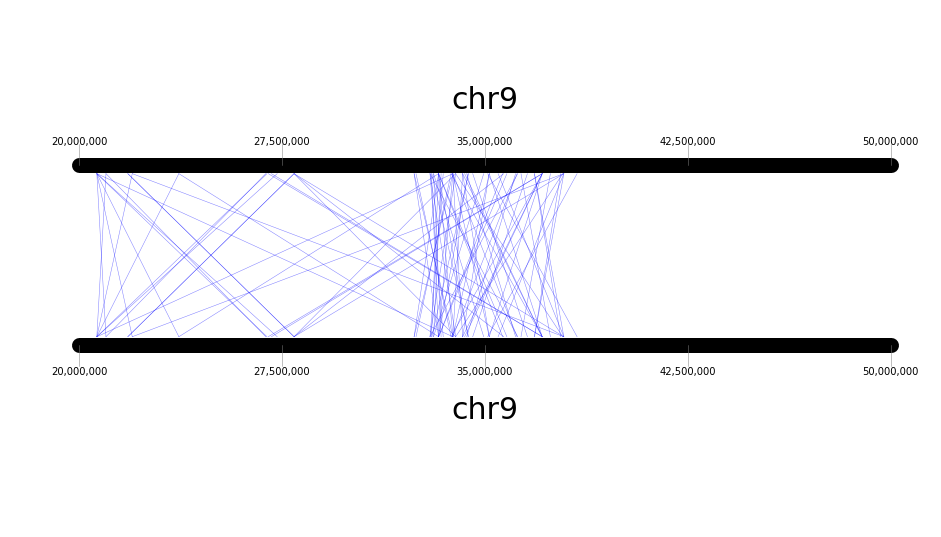

In [15]:
fig_futra = plot_interactions(futra, 'chr9', (20000000, 50000000), 'chr9', (20000000, 50000000), line_color='blue',
                              alpha = 0.5, linewidth = 0.5, output=outputs, name ='Futra', symmetric=True)

**Significant genes**

In [22]:
sig_genes = futra.loc[(futra['Gene_A'].isin(['WDR74', 'FRMD8', 'NEAT1', 'AHNAK'])) | (futra['Gene_B'].isin(['WDR74', 'FRMD8', 'NEAT1', 'AHNAK']))]

In [25]:
sig_genes[sig_genes.columns[:6]].reset_index(drop=True)

,Cancer,sampleId,Gene_A,Gene_B,chrA,chrB
0,SKCM,EE.A2GT.06A,AHNAK,BIRC6,chr11,chr2
1,LUSC,85.8276.01A,AHNAK,DPF2,chr11,chr11
2,LUSC,NC.A5HH.01A,AHNAK,NXF1,chr11,chr11
3,BRCA,A8.A09E.01A,AHNAK,RPS6KA4,chr11,chr11
4,LUAD,97.7937.01A,AHNAK,STIP1,chr11,chr11
5,HNSC,CR.6474.01A,AHNAK,SUPT16H,chr11,chr14
6,LAML,AB.2835.03A,AHNAK,TYK2,chr11,chr19
7,BRCA,AC.A23H.01A,AHNAK,ZNF827,chr11,chr4
8,PRAD,EJ.7784.01A,AHNAK,ZNFX1,chr11,chr20
9,BRCA,GM.A2DF.01A,ARHGEF17,WDR74,chr11,chr11
